<a href="https://colab.research.google.com/github/AhlamBashiti1/MedCUI_ML_Project/blob/main/ImageModelUpdated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/sctg-development/ROCOv2-radiology.git

Cloning into 'ROCOv2-radiology'...
remote: Enumerating objects: 80464, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 80464 (delta 6), reused 1 (delta 1), pack-reused 80454 (from 3)
Receiving objects: 100% (80464/80464), 5.89 GiB | 23.43 MiB/s, done.
Resolving deltas: 100% (1745/1745), done.
Updating files: 100% (79808/79808), done.


In [12]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops, hog
from skimage.filters import sobel
from scipy.fft import fft

# ======================== Feature Extraction ===========================
'''
def extract_lbp_features(img_gray, P=8, R=1):
    lbp = local_binary_pattern(img_gray, P, R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P+3), range=(0, P+2))
    hist = hist.astype('float')
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_hog_features(img_gray):
    features, _ = hog(img_gray, pixels_per_cell=(16, 16), cells_per_block=(2, 2), visualize=True)
    return features

def extract_glcm_features(img_gray):
    glcm = graycomatrix(img_gray, distances=[1], angles=[0], symmetric=True, normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    return [graycoprops(glcm, p)[0, 0] for p in props]

def extract_moment_features(img_gray):
    m = cv2.moments(img_gray)
    return [m['m00'], m['m01'], m['m10'], m['mu20'], m['mu11'], m['mu02']]

def extract_edge_features(img_gray):
    edge = sobel(img_gray)
    hist, _ = np.histogram(edge.ravel(), bins=10, range=(0, 1))
    hist = hist.astype('float')
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_fourier_descriptors(img_gray, num_descriptors=10):
    _, thresh = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        return np.zeros(num_descriptors)
    cnt = max(contours, key=cv2.contourArea)
    cnt = cnt.reshape(-1, 2)  # prevent scalar indexing error

    complex_cnt = np.array([complex(p[0], p[1]) for p in cnt])
    fourier_result = fft(complex_cnt)
    desc = np.abs(fourier_result[1:num_descriptors+1])
    desc /= (np.linalg.norm(desc) + 1e-6)
    return desc

def extract_features(image_path, size=(128, 128)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found: {image_path}")
    img = cv2.resize(img, size)
    return np.concatenate([
        extract_lbp_features(img),
        extract_hog_features(img),
        extract_glcm_features(img),
        extract_moment_features(img),
        extract_edge_features(img),
        extract_fourier_descriptors(img)
    ])
'''
def extract_lbp_features(img_gray, P=8, R=1):
    lbp = local_binary_pattern(img_gray, P, R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P+3), range=(0, P+2))
    hist = hist.astype('float')
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_hog_features(img_gray):
    features, _ = hog(img_gray,
                      pixels_per_cell=(16, 16),
                      cells_per_block=(2, 2),
                      visualize=True)
    return features

def extract_glcm_features(img_gray):
    glcm = graycomatrix(img_gray, distances=[1], angles=[0], symmetric=True, normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    return [graycoprops(glcm, p)[0, 0] for p in props]

def extract_features(image_path, size=(128, 128)):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Image not found: {image_path}")
    img = cv2.resize(img, size)
    f1 = extract_lbp_features(img)
    f2 = extract_hog_features(img)
    f3 = extract_glcm_features(img)
    return np.concatenate([f1, f2, f3])

In [13]:

def load_data(csv_path, image_dir, resize=(128, 128), ext=".jpg"):
    df = pd.read_csv(csv_path)

    label_columns = [str(i) for i in range(4)]  # only labels 0,1,2,3
    labels = df[label_columns].values
    feature_list = []

    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_path = os.path.join(image_dir, row['ID'] + ext)
        try:
            features = extract_features(img_path, resize)
            feature_list.append(features)
        except Exception as e:
            print(f"Error with {img_path}: {e}")

    return np.stack(feature_list), labels


In [14]:
from tqdm import tqdm

# Adjust paths as needed
train_csv = "/content/Train_with_clusters.csv"
val_csv = "/content/Val_with_clusters.csv"
test_csv = "/content/Test_with_clusters.csv"

train_img_dir = "/content/ROCOv2-radiology/source_dataset/train"
val_img_dir = "/content/ROCOv2-radiology/source_dataset/valid"
test_img_dir = "/content/ROCOv2-radiology/source_dataset/test"

# Load all sets
X_train, y_train = load_data(train_csv, train_img_dir)
X_val, y_val = load_data(val_csv, val_img_dir)
X_test, y_test = load_data(test_csv, test_img_dir)

print("Shapes:", X_train.shape, y_train.shape)

100%|██████████| 9927/9927 [04:11<00:00, 39.42it/s]


Shapes: (59957, 1779) (59957, 4)


In [31]:
# Assume X_train, y_train, X_test, y_test are already loaded
from sklearn.model_selection import train_test_split

# Example only: load your data correctly
# X, y = features_array, label_array
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"PCA reduced from {X_train.shape[1]} to {X_train_pca.shape[1]} dimensions.")

# Evaluation dictionary
results = {}

def train_and_evaluate(name, base_model, use_pca=False):
    print(f"\n===== {name} {'+ PCA' if use_pca else ''} =====")
    clf = MultiOutputClassifier(base_model, n_jobs=-1)

    X_tr = X_train_pca if use_pca else X_train
    X_te = X_test_pca if use_pca else X_test

    clf.fit(X_tr, y_train)
    y_pred = clf.predict(X_te)

    f1 = f1_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')

    results[name + (' + PCA' if use_pca else '')] = {
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

    print(classification_report(y_test, y_pred))


PCA reduced from 1779 to 1 dimensions.


In [32]:
from sklearn.linear_model import LogisticRegression

train_and_evaluate("LogisticRegression", LogisticRegression(solver='liblinear', max_iter=1000), use_pca=True)



===== LogisticRegression + PCA =====
              precision    recall  f1-score   support

           0       0.55      0.77      0.64      5315
           1       0.89      1.00      0.94      8808
           2       0.00      0.00      0.00      2031
           3       0.67      0.99      0.80      6649

   micro avg       0.72      0.86      0.78     22803
   macro avg       0.53      0.69      0.59     22803
weighted avg       0.67      0.86      0.75     22803
 samples avg       0.72      0.88      0.76     22803



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [33]:
from sklearn.svm import LinearSVC

train_and_evaluate("LinearSVC", OneVsRestClassifier(LinearSVC(max_iter=2000)), use_pca=True)



===== LinearSVC + PCA =====
              precision    recall  f1-score   support

           0       0.55      0.77      0.64      5315
           1       0.89      1.00      0.94      8808
           2       0.00      0.00      0.00      2031
           3       0.67      1.00      0.80      6649

   micro avg       0.72      0.86      0.78     22803
   macro avg       0.53      0.69      0.59     22803
weighted avg       0.67      0.86      0.75     22803
 samples avg       0.72      0.88      0.76     22803



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
# Without PCA (work fine with high dimensions)
train_and_evaluate("Random Forest", RandomForestClassifier(n_estimators=100, n_jobs=-1), use_pca=False)
train_and_evaluate("AdaBoost", AdaBoostClassifier(n_estimators=100), use_pca=False)
train_and_evaluate("Decision Tree", DecisionTreeClassifier(), use_pca=False)

# With PCA (better for high-dim sensitive classifiers)
train_and_evaluate("K-Nearest Neighbors", KNeighborsClassifier(n_neighbors=5, n_jobs=-1), use_pca=True)
train_and_evaluate("SVM", SVC(probability=True, kernel='rbf'), use_pca=True)
train_and_evaluate("Naïve Bayes", GaussianNB(), use_pca=True)



===== Random Forest  =====
              precision    recall  f1-score   support

           0       0.63      0.55      0.59      5315
           1       0.89      1.00      0.94      8808
           2       0.96      0.08      0.15      2031
           3       0.71      0.94      0.81      6649

   micro avg       0.78      0.79      0.78     22803
   macro avg       0.80      0.64      0.62     22803
weighted avg       0.79      0.79      0.75     22803
 samples avg       0.78      0.82      0.77     22803


===== AdaBoost  =====


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.61      0.56      0.58      5315
           1       0.91      0.98      0.94      8808
           2       0.74      0.09      0.16      2031
           3       0.73      0.87      0.79      6649

   micro avg       0.78      0.77      0.77     22803
   macro avg       0.75      0.63      0.62     22803
weighted avg       0.77      0.77      0.75     22803
 samples avg       0.79      0.80      0.76     22803


===== Decision Tree  =====


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.58      0.55      0.56      5315
           1       0.92      0.87      0.89      8808
           2       0.27      0.30      0.29      2031
           3       0.73      0.71      0.72      6649

   micro avg       0.72      0.70      0.71     22803
   macro avg       0.62      0.61      0.62     22803
weighted avg       0.72      0.70      0.71     22803
 samples avg       0.72      0.72      0.68     22803


===== K-Nearest Neighbors + PCA =====
              precision    recall  f1-score   support

           0       0.54      0.54      0.54      5315
           1       0.89      0.98      0.93      8808
           2       0.21      0.08      0.12      2031
           3       0.67      0.79      0.73      6649

   micro avg       0.72      0.74      0.73     22803
   macro avg       0.58      0.60      0.58     22803
weighted avg       0.68      0.74      0.71     22803
 samples avg       0.73      0.77     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m


===== Summary Table =====
                               F1  Precision  Recall
Random Forest              0.6225     0.8011  0.6414
AdaBoost                   0.6203     0.7457  0.6258
Decision Tree              0.6162     0.6229  0.6103
K-Nearest Neighbors + PCA  0.5796     0.5797  0.5980
SVM + PCA                  0.5469     0.5399  0.5882
Naïve Bayes + PCA          0.5946     0.5258  0.6900


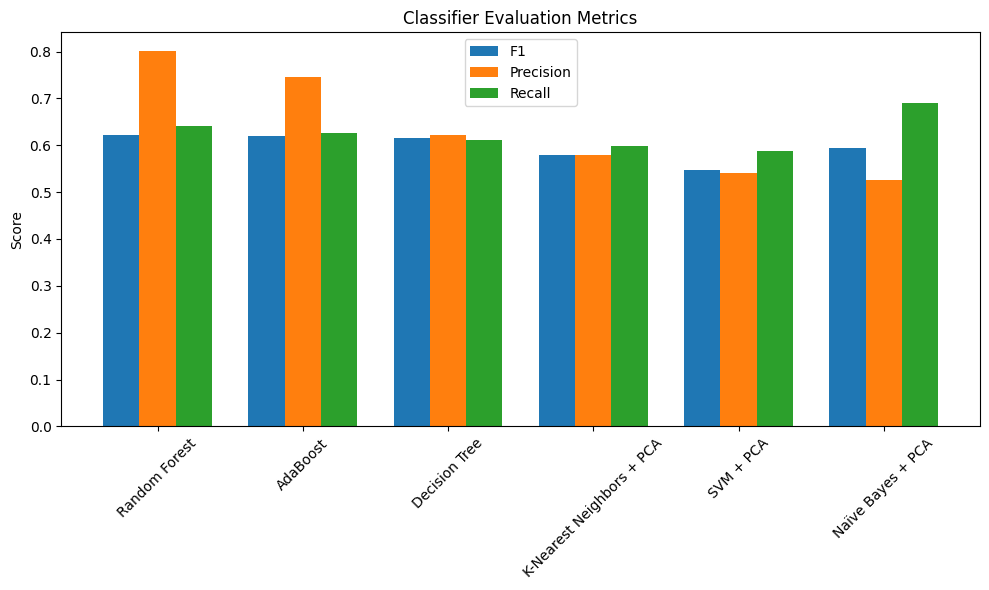

In [17]:
# Create DataFrame from results
results_df = pd.DataFrame.from_dict(results, orient='index')
print("\n===== Summary Table =====")
print(results_df.round(4))

# Save to CSV
results_df.to_csv("model_evaluation_summary.csv")

# Plotting
metrics = ['F1', 'Precision', 'Recall']
x = np.arange(len(results_df))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
for i, metric in enumerate(metrics):
    scores = results_df[metric]
    ax.bar(x + i * width, scores, width, label=metric)

ax.set_xticks(x + width)
ax.set_xticklabels(results_df.index, rotation=45)
ax.set_ylabel("Score")
ax.set_title("Classifier Evaluation Metrics")
ax.legend()
plt.tight_layout()
plt.show()
